# <center>Organizaci&oacute;n de Datos</center>
## <center>Trabajo Práctico 2: Criticas de cine</center>

#### Integrantes grupo 19: Sudanalytics 
* Adrian Leandro Re
* Alan Toulouse
* Luciano Lorenzo
* Nicolas Tonizzo

Importamos las librerias y modulos necesarios.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import make_scorer, f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

Cargamos nuestro set de entrenamiento

In [2]:
df = pd.read_csv("dataset/train.csv")
df.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Feature Engineering

Primero verificamos que no haya ningun valor nulo en nuestro dataframe, ya que no tendria sentido hacer el analisis de sentimientos a partir de una review vacía.

In [3]:
df['review_es'].isnull().sum()

0

Encodeamos el target para que las review positivas esten representadas por un 1 y las negativas por 0.

In [4]:
df['sentimiento_es_positivo'] = np.where(df.sentimiento == 'positivo', 1, 0)

Pasamos todos los caracteres a minúscula para que sea más fácil preporcesarlos.

In [5]:
df['review_es'] = df['review_es'].str.lower()

Quitamos los acentos de todas las palabras y reemplazamos el caracter ñ por n.

In [6]:
caracteres_especiales = {'á':'a', 'é':'e', 'í':'i', 'ó':'o', 'ú':'u', 'ñ':'n'}
for original, nuevo in caracteres_especiales.items():
    df['review_es'] = df['review_es'].str.replace(original, nuevo, regex=True)

Removemos todo caracter que no sean letras (números, puntos, comas, comillas, etc.) y los espacios dobles que puedan llegar a aparecer con esta operación.

In [7]:
df['review_es'] = df['review_es'].str.replace('[^a-zA-Z]', ' ', regex=True)
df['review_es'] = df['review_es'].str.replace('  ', ' ', regex=True)

Como último paso para el preprocesamiento, eliminamos las stopwords

In [8]:
from nltk.corpus import stopwords
palabras = '|'.join(stopwords.words('spanish'))
df['review_es'] = df['review_es'].str.replace(fr'\b({palabras})\b', '',regex=True)

Nuestro dataset preprocesado queda de la siguiente manera:

In [9]:
df.head(15)

,ID,review_es,sentimiento,sentimiento_es_positivo
0,0,criticos mencionado despues ver solo o...,positivo,1
1,1,pequena pequena produccion tecnica filmacio...,positivo,1
2,2,pense manera maravillosa pasar tiempo f...,positivo,1
3,3,basicamente familia nino pequeno jake pien...,negativo,0
4,4,amor tiempo petter mattei pelicula visua...,positivo,1
5,5,probablemente pelicula favorita tiempos h...,positivo,1
6,6,seguro gustaria ver resurreccion serie s...,positivo,1
7,7,espectaculo idea increible fresca innovado...,negativo,0
8,8,alentados comentarios positivos pelicula a...,negativo,0
9,9,si gusta risa original desgarradora gustara...,positivo,1


## Sets de test y train
Dividimos el dataframe en datos de test y train. Usaremos estos mismos sets para el entrenamiento de todos los modelos.

In [105]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

X = df.review_es
y = df.sentimiento_es_positivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

## Ensamblado de modelos

### Bayes Naive
Primero transformamos nuestros documentos en una matriz en la cual se almacena la cantidad de tokens ("palabras clave"). Luego convertimos esa misma matriz en una representación normalizada de término/frecuencia. 
Esto lo hacemos para reducir el impacto de los tokens que aparecen más veces.

In [106]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

vectorizador = CountVectorizer()
X_train_counts = vectorizador.fit_transform(X_train)

escaladorTfidf = TfidfTransformer()
X_train_tfidf = escaladorTfidf.fit_transform(X_train_counts)

print(X_train_tfidf)

  (0, 151956)	0.07839375983945933
  (0, 151166)	0.11323120376010341
  (0, 150776)	0.08902974801322862
  (0, 149990)	0.07465001685823258
  (0, 149669)	0.07447143467830195
  (0, 147913)	0.10162340869422316
  (0, 146910)	0.14883229052925429
  (0, 144470)	0.14883229052925429
  (0, 140314)	0.12501222871042422
  (0, 139438)	0.08390310466935802
  (0, 139343)	0.06384473070243955
  (0, 139053)	0.24962846284902818
  (0, 137803)	0.12154780116327625
  (0, 135914)	0.11291771666467475
  (0, 135710)	0.10344786027627755
  (0, 134565)	0.11062648715600867
  (0, 131011)	0.1295656000608667
  (0, 129473)	0.1530257136075339
  (0, 128411)	0.2538159476458894
  (0, 126504)	0.10411054657793721
  (0, 117107)	0.13547589793687673
  (0, 109407)	0.08570497439079185
  (0, 107610)	0.09367171688551747
  (0, 106571)	0.09479023379855103
  (0, 103701)	0.09649593451515524
  :	:
  (39999, 16409)	0.06953640167761231
  (39999, 16025)	0.019221553286145755
  (39999, 15386)	0.06314997104237892
  (39999, 12029)	0.0546795797400099

Ahora que tenemos la información en el formato correcto, creamos nuestro modelo de tipo Bayes Naive. En este caso usamos uno de tipo multinomial.

In [107]:
clasificadorBayesNaive = MultinomialNB()
clasificadorBayesNaive.fit(X_train_tfidf, y_train)

MultinomialNB()

Realizamos el mismo procedimiento para transformar los datos de validación y poder realizar nuestras predicciones.

In [108]:
X_test_counts = vectorizador.transform(X_test)
X_test_tfidf = escaladorTfidf.transform(X_test_counts)
y_pred = np.where(clasificadorBayesNaive.predict(X_test_tfidf) >= 0.5, 1, 0)

Construimos nuestra matriz de confusión y analizamos métricas

Text(0.5, 1.0, 'Confusion matrix de validación')

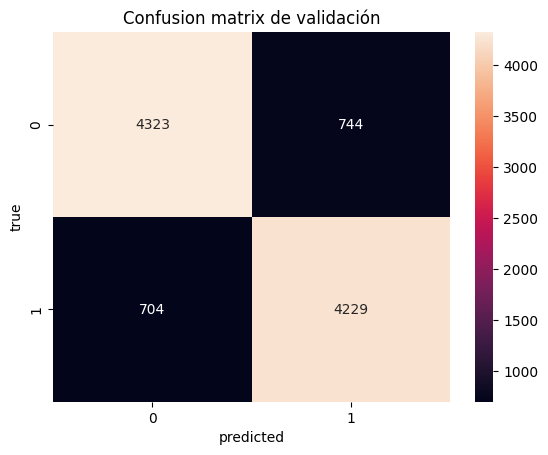

In [109]:
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de validación")

In [110]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.8552
Precision: 0.8503921174341443
Recall: 0.8572876545712548
F1-score: 0.8538259640621845


Creamos el submit para la competencia de Kaggle.

In [16]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test['review_es']
    
X_counts = vectorizador.transform(X)
X_tfidf = escaladorTfidf.transform(X_counts)
    
prediccion = np.where(clasificadorBayesNaive.predict(X_tfidf) >= 0.5, 'positivo', 'negativo')

assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

### Cross validation naive bayes

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [113]:
clf_naive_bayes = MultinomialNB(fit_prior=False)

params_grid2 = {
    "alpha": np.linspace(0.3,1,40),
}

kfoldcv = StratifiedKFold(n_splits=6)

model = GridSearchCV (
    estimator=clf_naive_bayes,
    param_grid=params_grid2,
    scoring=make_scorer(f1_score),
    cv=kfoldcv,
)

model.fit(X_train_tfidf, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=MultinomialNB(fit_prior=False),
             param_grid={'alpha': array([0.3       , 0.31794872, 0.33589744, 0.35384615, 0.37179487,
       0.38974359, 0.40769231, 0.42564103, 0.44358974, 0.46153846,
       0.47948718, 0.4974359 , 0.51538462, 0.53333333, 0.55128205,
       0.56923077, 0.58717949, 0.60512821, 0.62307692, 0.64102564,
       0.65897436, 0.67692308, 0.69487179, 0.71282051, 0.73076923,
       0.74871795, 0.76666667, 0.78461538, 0.8025641 , 0.82051282,
       0.83846154, 0.85641026, 0.87435897, 0.89230769, 0.91025641,
       0.92820513, 0.94615385, 0.96410256, 0.98205128, 1.        ])},
             scoring=make_scorer(f1_score))

In [114]:
print("Los mejores parametros encontrados son: ", model.best_params_)
print("con un f1 score: ", model.best_score_)

Los mejores parametros encontrados son:  {'alpha': 0.8384615384615384}
con un f1 score:  0.8583055484472998


In [115]:
pd.DataFrame(model.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
30,0.038959,0.010789,0.014717,0.002078,0.838462,{'alpha': 0.8384615384615384},0.847203,0.856112,0.872079,0.856631,0.859982,0.857826,0.858306,0.007344,1
29,0.033854,0.005812,0.005209,0.007366,0.820513,{'alpha': 0.8205128205128205},0.847249,0.856112,0.872379,0.856333,0.860238,0.857484,0.858299,0.007454,2
16,0.031304,0.000022,0.000000,0.000000,0.587179,{'alpha': 0.5871794871794871},0.848539,0.856885,0.871142,0.856760,0.859072,0.856930,0.858221,0.006671,3
31,0.045565,0.010138,0.006544,0.007015,0.85641,{'alpha': 0.8564102564102563},0.847422,0.855811,0.872079,0.856504,0.859898,0.857484,0.858200,0.007312,4
28,0.043107,0.012746,0.012698,0.010203,0.802564,{'alpha': 0.8025641025641026},0.847249,0.856112,0.871741,0.856035,0.860539,0.857356,0.858172,0.007286,5


In [116]:
X_test_counts = vectorizador.transform(X_test)
X_test_tfidf = escaladorTfidf.transform(X_test_counts)
y_pred = np.where(model.predict(X_test_tfidf) >= 0.5, 1, 0)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.8564
Precision: 0.8521651560926485
Recall: 0.8576930873707683
F1-score: 0.8549201858961406


Creamos submit para competencia Kaggle

In [22]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test['review_es']
    
X_counts = vectorizador.transform(X)
X_tfidf = escaladorTfidf.transform(X_counts)
    
prediccion = np.where(model.predict(X_tfidf) >= 0.5, 'positivo', 'negativo')

assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

Guardamos el model para ser usado mas tarde en el ensamble

In [117]:
with open('modelos/BayesNaiveCV.pickle', 'wb') as file:
    pickle.dump(model, file)

### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [32]:
X = df.review_es
y = df.sentimiento_es_positivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=19)
vectorizador = CountVectorizer()
escaladorTfidf = TfidfTransformer()
X_train_counts_2 = vectorizador.fit_transform(X_train)
X_train_tfidf_2 = escaladorTfidf.fit_transform(X_train_counts_2)
X_test_counts_2 = vectorizador.transform(X_test)
X_test_tfidf_2 = escaladorTfidf.transform(X_test_counts_2)

Probamos RF con sus parametros por defecto y analizamos sus resultados en train y test

In [ ]:
rfc_default = RandomForestClassifier()
model = rfc_default.fit(X = X_train_counts_2, y = y_train)

In [ ]:
print("f1 score sobre train: ", f1_score(y_train, rfc_default.predict(X_train_counts_2)))

In [ ]:
print("f1 score sobre validacion: ", f1_score(y_test, rfc_default.predict(X_test_counts_2)))

Buscamos los mejores hiperparametros

In [33]:
rf_cv = RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [10,25,50,75,100], 
               "n_estimators": [100,150,200,250,300],
               "oob_score":[False, True],
               "random_state":[1],
               "n_jobs":[-1]}

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs_fit = gs.fit(X = X_train_counts_2, y = y_train)

In [34]:
gs_fit.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 10,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1}

In [36]:
rf_cv_best=gs_fit.best_estimator_

In [37]:
print("f1 score sobre train: ", f1_score(y_train, rf_cv_best.predict(X_train_counts_2)))

f1 score sobre train:  0.8939372015627262


In [38]:
print("f1 score sobre validacion: ", f1_score(y_test, rf_cv_best.predict(X_test_counts_2)))

f1 score sobre validacion:  0.8506922951620784


In [39]:
y_pred = rf_cv_best.predict(X_test_counts_2)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

F1 Score: 0.8506922951620784
Precision: 0.8257542217443552
Recall: 0.8771835528083849
Accuracy: 0.8472333333333333


Text(0.5, 1.0, 'Confusion matrix de training set')

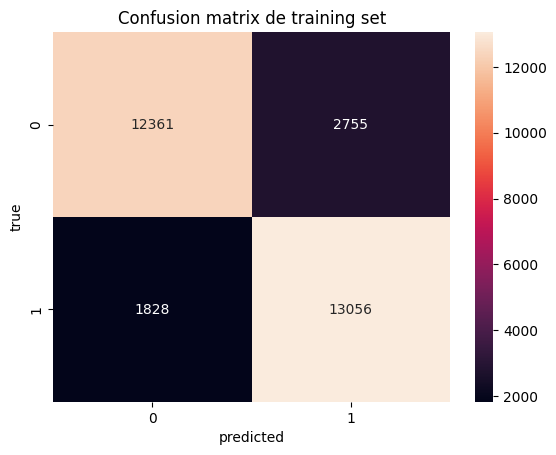

In [40]:
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de training set")

In [41]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test['review_es']
    
X_counts = vectorizador.transform(X)
X_tfidf = escaladorTfidf.transform(X_counts)
    
prediccion = np.where(rf_cv_best.predict(X_tfidf) >= 0.5, 'positivo', 'negativo')

assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

Guardamos el modelo para ser usado mas tarde en el ensamble

In [128]:
with open('modelos/RandomForestCV.pickle', 'wb') as file:
    pickle.dump(rf_cv_best, file)

### XGBoost

In [46]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [47]:
vectorizador = CountVectorizer()
escaladorTfidf = TfidfTransformer()
X_train_counts_1 = vectorizador.fit_transform(X_train)
X_train_tfidf_1 = escaladorTfidf.fit_transform(X_train_counts_1)
X_test_counts_1 = vectorizador.transform(X_test)
X_test_tfidf_1 = escaladorTfidf.transform(X_test_counts_1)


In [48]:
d_train = xgb.DMatrix(X_train_tfidf_1, label=y_train)
d_test = xgb.DMatrix(X_test_tfidf_1, label=y_test)

In [ ]:
clf = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000, early_stopping_rounds=50)

clf.fit(X_train_tfidf_1, y_train,
       eval_set=[(X_train_tfidf_1, y_train), (X_test_tfidf_1, y_test)],
       verbose=50)

[0]	validation_0-logloss:0.67379	validation_1-logloss:0.67467
[50]	validation_0-logloss:0.44841	validation_1-logloss:0.48307
[100]	validation_0-logloss:0.37940	validation_1-logloss:0.43327
[150]	validation_0-logloss:0.33638	validation_1-logloss:0.40626
[200]	validation_0-logloss:0.30557	validation_1-logloss:0.38813
[250]	validation_0-logloss:0.28090	validation_1-logloss:0.37476
[300]	validation_0-logloss:0.26092	validation_1-logloss:0.36480
[350]	validation_0-logloss:0.24460	validation_1-logloss:0.35689
[400]	validation_0-logloss:0.22972	validation_1-logloss:0.35017
[450]	validation_0-logloss:0.21787	validation_1-logloss:0.34477
[500]	validation_0-logloss:0.20686	validation_1-logloss:0.33987
[550]	validation_0-logloss:0.19707	validation_1-logloss:0.33619
[600]	validation_0-logloss:0.18799	validation_1-logloss:0.33256
[650]	validation_0-logloss:0.17969	validation_1-logloss:0.32937
[700]	validation_0-logloss:0.17271	validation_1-logloss:0.32663
[750]	validation_0-logloss:0.16597	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
print("f1 score sobre validacion: ", f1_score(y_test, clf.predict(X_test_tfidf_1)))
print("f1 score sobre train: ", f1_score(y_train, clf.predict(X_train_tfidf_1)))

f1 score sobre validacion:  0.8629673826571201
f1 score sobre train:  0.9805899661251638


In [ ]:
clf2 = xgb.XGBClassifier(learning_rate=0.1,
                         max_depth=10,
                         subsample=0.8,
                         reg_lambda = 4,
                         reg_alpha = 3,
                         nthread = -1,
                         n_estimators=1000, early_stopping_rounds=50)

clf2.fit(X_train_tfidf_1, y_train,
       eval_set=[(X_train_tfidf_1, y_train), (X_test_tfidf_1, y_test)],
       verbose=50)

[0]	validation_0-logloss:0.66882	validation_1-logloss:0.67042
[50]	validation_0-logloss:0.39136	validation_1-logloss:0.44845
[100]	validation_0-logloss:0.31287	validation_1-logloss:0.39965
[150]	validation_0-logloss:0.26653	validation_1-logloss:0.37553
[200]	validation_0-logloss:0.23447	validation_1-logloss:0.35980
[250]	validation_0-logloss:0.20990	validation_1-logloss:0.34838
[300]	validation_0-logloss:0.18886	validation_1-logloss:0.34061
[350]	validation_0-logloss:0.17235	validation_1-logloss:0.33435
[400]	validation_0-logloss:0.15860	validation_1-logloss:0.33024
[450]	validation_0-logloss:0.14577	validation_1-logloss:0.32639
[500]	validation_0-logloss:0.13424	validation_1-logloss:0.32381
[550]	validation_0-logloss:0.12450	validation_1-logloss:0.32132
[600]	validation_0-logloss:0.11566	validation_1-logloss:0.32008
[650]	validation_0-logloss:0.10804	validation_1-logloss:0.31955
[700]	validation_0-logloss:0.10019	validation_1-logloss:0.31919
[714]	validation_0-logloss:0.09841	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=-1,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
print("f1 score sobre validacion: ", f1_score(y_test, clf2.predict(X_test_tfidf_1)))
print("f1 score sobre train: ", f1_score(y_train, clf2.predict(X_train_tfidf_1)))

f1 score sobre validacion:  0.8564593301435406
f1 score sobre train:  0.9852050441862775


In [ ]:
clf3 = xgb.XGBClassifier(learning_rate=0.1,
                         max_depth=14,
                         subsample=0.9,
                         gamma = 7,
                         reg_lambda = 4,
                         reg_alpha = 3,
                         nthread = -1,
                         n_estimators=800, early_stopping_rounds=50)

clf3.fit(X_train_tfidf_1, y_train,
       eval_set=[(X_train_tfidf_1, y_train), (X_test_tfidf_1, y_test)],
       verbose=50)

[0]	validation_0-logloss:0.66579	validation_1-logloss:0.66877
[50]	validation_0-logloss:0.38087	validation_1-logloss:0.43420
[100]	validation_0-logloss:0.32384	validation_1-logloss:0.39058
[150]	validation_0-logloss:0.29430	validation_1-logloss:0.36886
[200]	validation_0-logloss:0.27395	validation_1-logloss:0.35389
[250]	validation_0-logloss:0.25829	validation_1-logloss:0.34417
[300]	validation_0-logloss:0.24883	validation_1-logloss:0.33855
[350]	validation_0-logloss:0.24543	validation_1-logloss:0.33679
[400]	validation_0-logloss:0.24399	validation_1-logloss:0.33587
[450]	validation_0-logloss:0.24286	validation_1-logloss:0.33528
[500]	validation_0-logloss:0.24198	validation_1-logloss:0.33488
[550]	validation_0-logloss:0.24127	validation_1-logloss:0.33457
[600]	validation_0-logloss:0.24073	validation_1-logloss:0.33433
[650]	validation_0-logloss:0.23972	validation_1-logloss:0.33389
[700]	validation_0-logloss:0.23892	validation_1-logloss:0.33333
[750]	validation_0-logloss:0.23801	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=7, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, nthread=-1, num_parallel_tree=None,
              predictor=None, ...)

In [ ]:
print("f1 score sobre validacion: ", f1_score(y_test, clf3.predict(X_test_tfidf_1)))
print("f1 score sobre train: ", f1_score(y_train, clf3.predict(X_train_tfidf_1)))

f1 score sobre validacion:  0.852952913008779
f1 score sobre train:  0.9214765265720679


In [53]:
param_grid = {
'learning_rate': [0.01, 0.1, 0.2],
'max_depth': [3, 5, 7, 10],
'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
'reg_lambda': [0.1, 1, 10],
'reg_alpha': [0.1, 1, 10],
'n_estimators': [100, 500, 1000]
}

xgb_clf = xgb.XGBClassifier()

grid = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, cv=3, n_iter=10, scoring=make_scorer(f1_score), n_jobs = -1)
grid.fit(X_train_tfidf_1, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
grid.best_params_

{'subsample': 0.8,
 'reg_lambda': 0.1,
 'reg_alpha': 1,
 'n_estimators': 500,
 'max_depth': 5,
 'learning_rate': 0.2}

In [51]:
f1_score(y_test, grid.predict(X_test_tfidf_1))

NameError: name 'grid' is not defined

In [55]:
y_pred = grid.predict(X_test_tfidf_1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

F1 Score: 0.8518310231896523
Precision: 0.8390355164548713
Recall: 0.8650228433216878
Accuracy: 0.8507


Text(0.5, 1.0, 'Confusion matrix de training set')

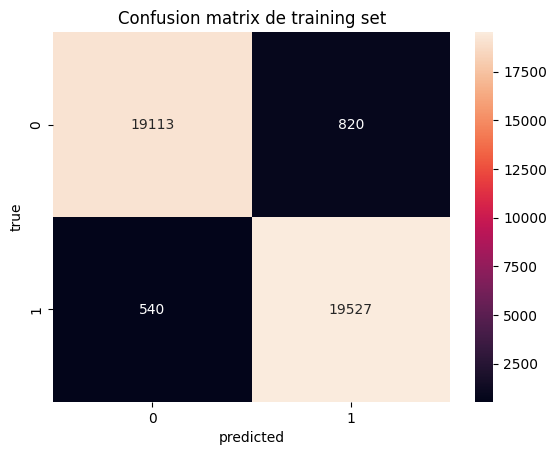

In [ ]:
y_pred = grid.predict(X_train_tfidf_1)
confusion = confusion_matrix(y_train, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de training set")

In [56]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test['review_es']    
X_counts = vectorizador.transform(X)
X_tfidf = escaladorTfidf.transform(X_counts)
    
prediccion = np.where(grid.predict(X_tfidf) >= 0.5, 'positivo', 'negativo')
assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

NameError: name 'grid' is not defined

In [57]:
with open('modelos/XgBoostCV.pickle', 'wb') as file:
    pickle.dump(grid, file)

### Red neuronal con Keras y TensorFlow

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Embedding, Dense
from keras.utils import pad_sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocabulario = len(tokenizer.word_index) + 1

In [ ]:
max_words = 5000
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_words)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_words)

In [ ]:
lstm_nn = Sequential()

lstm_nn.add(Embedding(vocabulario, 32, input_length=max_words,trainable=False))
lstm_nn.add(LSTM(100))
lstm_nn.add(Dense(1,activation='sigmoid'))

In [ ]:
lstm_nn.compile(optimizer='adam', loss='binary_crossentropy')
print(lstm_nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 32)          4889824   
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 4,943,125
Trainable params: 53,301
Non-trainable params: 4,889,824
_________________________________________________________________
None


In [ ]:
lstm_nn_history = lstm_nn.fit(X_train_padded, y_train, epochs=6)

In [ ]:
y_pred = np.where(lstm_nn.predict(X_test_padded) >= 0.5, 1, 0)

Text(0.5, 1.0, 'Confusion matrix de validación')

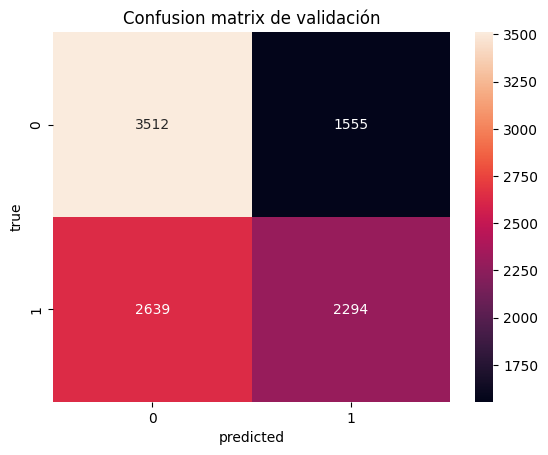

In [ ]:
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de validación")

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.5806
Precision: 0.5959989607690309
Recall: 0.46503142104196227
F1-score: 0.522432247779549


In [ ]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test.review_es
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_words)
    
prediccion = np.where(lstm_nn.predict(X_padded) >= 0.5, 'positivo', 'negativo').reshape(-1)
assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

### Ensamble de modelos

In [118]:
from sklearn.ensemble import VotingClassifier

In [129]:
bn = pickle.load(open('modelos/BayesNaiveCV.pickle', 'rb'))
rf = pickle.load(open('modelos/RandomForestCV.pickle', 'rb'))
xgb = pickle.load(open('modelos/XgBoostCV.pickle', 'rb'))

In [132]:
voting = VotingClassifier(estimators=[ ('rf', rf),('xgb', xgb),('bn', bn)], voting='hard')

In [125]:
X = df.review_es
y = df.sentimiento_es_positivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=19)
vectorizador = CountVectorizer()
escaladorTfidf = TfidfTransformer()
X_train_counts_3 = vectorizador.fit_transform(X_train)
X_train_tfidf_3 = escaladorTfidf.fit_transform(X_train_counts_3)
X_test_counts_3 = vectorizador.transform(X_test)
X_test_tfidf_3 = escaladorTfidf.transform(X_test_counts_3)

In [133]:
voting.fit(X_train_tfidf_3, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     min_samples_leaf=10,
                                                     n_estimators=300)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gp...
       0.47948718, 0.4974359 , 0.51538462, 0.53333333, 0.55128205,
       0.56923077, 0.58717949, 0.60512821, 0.62307692, 0.64102564,
       0.65897436, 0.67692308, 0.69487179, 0.71282051, 0.73076923,
       0.74871795, 0.76666667, 0.78461538, 0.8025641 , 0.82051282,
       0.83846154, 0.85641026, 0.87435897, 0.89230769, 0.91025641,
       0.92820513, 0.94615385, 0.96410256, 0.98205128, 1.        ])},
                                           scoring=make_scorer(f1_score)))])

In [134]:
print("f1 score sobre validacion con el ensamble de voting: ", f1_score(y_test, voting.predict(X_test_tfidf_3)))
print("f1 score sobre train con el modelo de voting: ", f1_score(y_train, voting.predict(X_train_tfidf_3 )))

f1 score sobre validacion con el ensamble de voting:  0.866429089949185
f1 score sobre train con el modelo de voting:  0.9566029390082076


Ploteamos matriz de confusion sobre el conjunto de validacion

Text(0.5, 1.0, 'Confusion matrix del validation set (voting)')

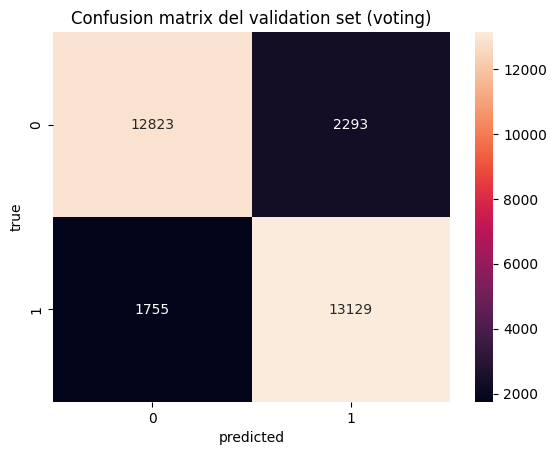

In [135]:
y_pred = voting.predict(X_test_tfidf_3)
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix del validation set (voting)")

Creamos submit para competencia Kaggle

In [136]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test['review_es']
    
X_counts = vectorizador.transform(X)
X_tfidf = escaladorTfidf.transform(X_counts)
    
prediccion = np.where(rf_cv_best.predict(X_tfidf) >= 0.5, 'positivo', 'negativo')

assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

Guardamos modelo con pickle

In [74]:
with open('modelos/Voting.pickle', 'wb') as file:
    pickle.dump(voting, file)